In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

import functions.data_wrangling as dw
import functions.eddy_feedback as ef 

# Daily-mean EFP

In [6]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/monthly'
file = 'jra55_psl_ubar_divFy_monthly_1958-2016.nc'

ds = xr.open_dataset(f'{path}/{file}')
# ds = ds.rename({'div1_pr': 'divFy'})
ds = ds[['ubar', 'divFy']]
ds

<xarray.Dataset> Size: 23MB
Dimensions:  (time: 708, level: 37, lat: 73)
Coordinates:
  * lat      (lat) float64 584B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * time     (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2016-12-31
  * level    (level) float64 296B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
Data variables:
    ubar     (time, level, lat) float32 8MB ...
    divFy    (time, level, lat) float64 15MB ...
Attributes:
    CDI:          Climate Data Interface version 1.6.3 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Thu Mar 30 10:33:19 2017: cdo remapbil,r144x73 ./1958_2016/...
    CDO:          Climate Data Operators version 1.6.3rc4 (http://code.zmaw.d...

In [7]:
efp_nh_1979_2016 = ef.calculate_efp(ds, data_type='reanalysis')
efp_sh_1979_2016 = ef.calculate_efp(ds, data_type='reanalysis', calc_south_hemis=True)

efp_nh_1958_2016 = ef.calculate_efp(ds, data_type='reanalysis_fulltime')
efp_sh_1958_2016 = ef.calculate_efp(ds, data_type='reanalysis_fulltime', calc_south_hemis=True)


print('EFP NH (1979-2016):', efp_nh_1979_2016)
print('EFP SH (1979-2016):', efp_sh_1979_2016)
print()
print('EFP NH (1958-2016):', efp_nh_1958_2016)
print('EFP SH (1958-2016):', efp_sh_1958_2016)

EFP NH (1979-2016): 0.386
EFP SH (1979-2016): 0.2114

EFP NH (1958-2016): 0.3255
EFP SH (1958-2016): 0.1793


# 1958-2016

In [8]:
djf = dw.seasonal_mean(ds, season='djf', cut_ends=True)
jas = dw.seasonal_mean(ds, season='jas', cut_ends=True)

sample_sizes = [58]

for sample in sample_sizes:
    num_bootstrap_samples = 1000
    # Bootstrap resampling over 'time' for DJF
    bootstrap_indices = np.random.choice(djf.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_djfsets = [djf.isel(time=idx) for idx in bootstrap_indices]
    
    efp_djf_values = []
    for item in bootstrap_djfsets:
        
        efp_djf = ef.calculate_efp(item, data_type='reanalysis', bootstrapping=True)
        efp_djf_values.append(efp_djf)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1958-2016_djf_efp_values.npy'
    np.save(save_path, efp_djf_values)
    
    #-------------------------------------

    # Bootstrap resampling over 'time' for JAS
    bootstrap_indices = np.random.choice(jas.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_jassets = [jas.isel(time=idx) for idx in bootstrap_indices]
    
    efp_jas_values = []
    for item in bootstrap_jassets:
        
        efp_jas = ef.calculate_efp(item, data_type='reanalysis', calc_south_hemis=True, bootstrapping=True)
        efp_jas_values.append(efp_jas)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1958-2016_jas_efp_values.npy'
    np.save(save_path, efp_jas_values)

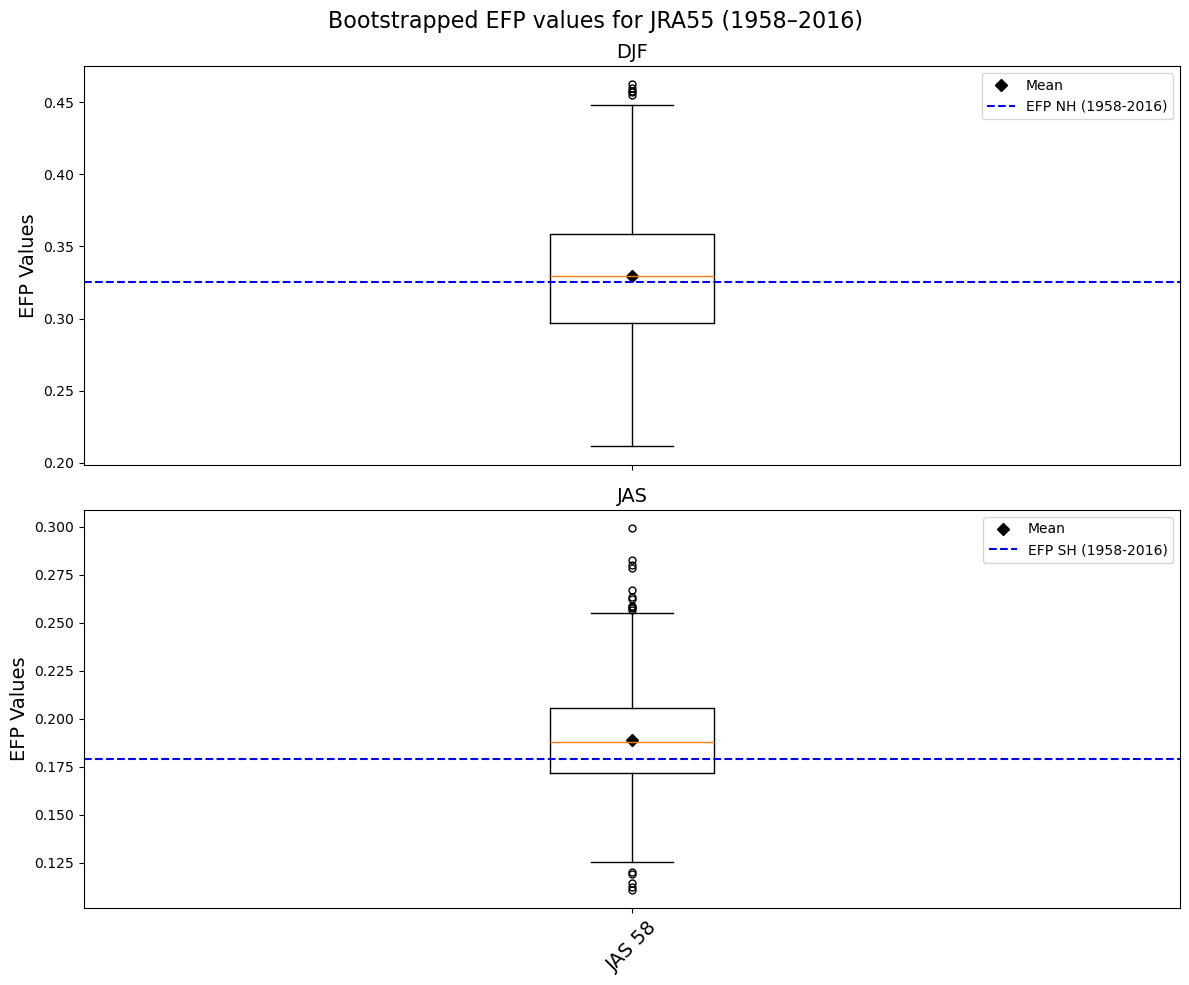

In [9]:


sample_sizes = [58]

# Containers for boxplot data and labels
all_djf_values = []
all_jas_values = []
labels_djf = []
labels_jas = []
mean_djf = []
mean_jas = []

for sample in sample_sizes:
    efp_djf_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1958-2016_djf_efp_values.npy')
    efp_jas_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1958-2016_jas_efp_values.npy')
    
    all_djf_values.append(efp_djf_values)
    all_jas_values.append(efp_jas_values)
    
    labels_djf.append(f'DJF {sample}')
    labels_jas.append(f'JAS {sample}')
    
    mean_djf.append(np.mean(efp_djf_values))
    mean_jas.append(np.mean(efp_jas_values))

# Create a single boxplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)

# DJF subplot
ax1.boxplot(all_djf_values, flierprops=dict(marker='o', color='r', markersize=5))
ax1.plot(np.arange(1, len(mean_djf)+1), mean_djf, 'D', color='black', label='Mean')
ax1.set_title('DJF', fontsize=14)
ax1.set_ylabel('EFP Values', fontsize=14)
ax1.set_xticks(ticks=np.arange(1, len(labels_djf)+1), labels=labels_djf, rotation=45, fontsize=14)
ax1.axhline(y=efp_nh_1958_2016, color='blue', linestyle='--', label='EFP NH (1958-2016)')
ax1.legend()

# JAS subplot
ax2.boxplot(all_jas_values, flierprops=dict(marker='o', color='r', markersize=5))
ax2.plot(np.arange(1, len(mean_jas)+1), mean_jas, 'D', color='black', label='Mean')
ax2.set_title('JAS', fontsize=14)
ax2.set_ylabel('EFP Values', fontsize=14)
ax2.set_xticks(ticks=np.arange(1, len(labels_jas)+1), labels=labels_jas, rotation=45, fontsize=14)
ax2.axhline(y=efp_sh_1958_2016, color='blue', linestyle='--', label='EFP SH (1958-2016)')
ax2.legend()

fig.suptitle('Bootstrapped EFP values for JRA55 (1958–2016)', fontsize=16)
plt.tight_layout()
plt.show()


# 1979-2016

In [10]:
ds = ds.sel(time=slice('1979', '2016'))

djf = dw.seasonal_mean(ds, season='djf', cut_ends=True)
jas = dw.seasonal_mean(ds, season='jas', cut_ends=True)

sample_sizes = [37]

for sample in sample_sizes:
    num_bootstrap_samples = 1000
    # Bootstrap resampling over 'time' for DJF
    bootstrap_indices = np.random.choice(djf.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_djfsets = [djf.isel(time=idx) for idx in bootstrap_indices]
    
    efp_djf_values = []
    for item in bootstrap_djfsets:
        
        efp_djf = ef.calculate_efp(item, data_type='reanalysis', bootstrapping=True)
        efp_djf_values.append(efp_djf)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1979-2016_djf_efp_values.npy'
    np.save(save_path, efp_djf_values)
    
    #-------------------------------------

    # Bootstrap resampling over 'time' for JAS
    bootstrap_indices = np.random.choice(jas.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_jassets = [jas.isel(time=idx) for idx in bootstrap_indices]
    
    efp_jas_values = []
    for item in bootstrap_jassets:
        
        efp_jas = ef.calculate_efp(item, data_type='reanalysis', calc_south_hemis=True, bootstrapping=True)
        efp_jas_values.append(efp_jas)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1979-2016_jas_efp_values.npy'
    np.save(save_path, efp_jas_values)

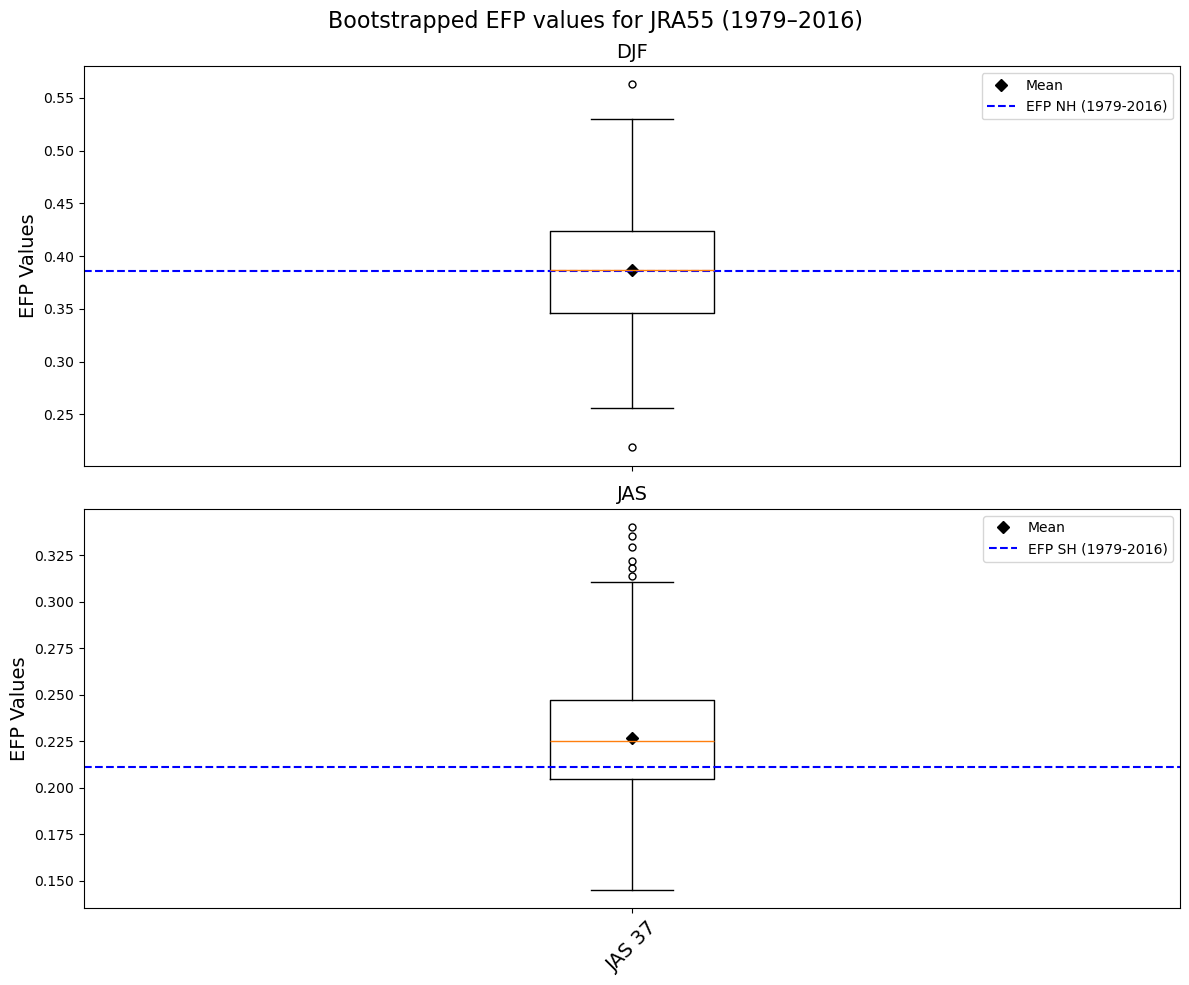

In [11]:
import numpy as np
import matplotlib.pyplot as plt

sample_sizes = [37]

# Containers for boxplot data, labels, and means
all_djf_values = []
all_jas_values = []
labels_djf = []
labels_jas = []
mean_djf = []
mean_jas = []

for sample in sample_sizes:
    efp_djf_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1979-2016_djf_efp_values.npy')
    efp_jas_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/daily/JRA55_1979-2016_jas_efp_values.npy')
    
    all_djf_values.append(efp_djf_values)
    all_jas_values.append(efp_jas_values)
    
    labels_djf.append(f'DJF {sample}')
    labels_jas.append(f'JAS {sample}')
    
    mean_djf.append(np.mean(efp_djf_values))
    mean_jas.append(np.mean(efp_jas_values))

# Create a single boxplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)

# DJF boxplot with means
ax1.boxplot(all_djf_values, flierprops=dict(marker='o', color='r', markersize=5))
ax1.plot(np.arange(1, len(mean_djf)+1), mean_djf, 'D', color='black', label='Mean')
ax1.set_title('DJF', fontsize=14)
ax1.set_ylabel('EFP Values', fontsize=14)
ax1.set_xticks(ticks=np.arange(1, len(labels_djf)+1), labels=labels_djf, rotation=45, fontsize=14)
ax1.axhline(y=efp_nh_1979_2016, color='blue', linestyle='--', label='EFP NH (1979-2016)')
ax1.legend()

# JAS boxplot with means
ax2.boxplot(all_jas_values, flierprops=dict(marker='o', color='r', markersize=5))
ax2.plot(np.arange(1, len(mean_jas)+1), mean_jas, 'D', color='black', label='Mean')
ax2.set_title('JAS', fontsize=14)
ax2.set_ylabel('EFP Values', fontsize=14)
ax2.set_xticks(ticks=np.arange(1, len(labels_jas)+1), labels=labels_jas, rotation=45, fontsize=14)
ax2.axhline(y=efp_sh_1979_2016, color='blue', linestyle='--', label='EFP SH (1979-2016)')
ax2.legend()

fig.suptitle('Bootstrapped EFP values for JRA55 (1979–2016)', fontsize=16)

plt.tight_layout()
plt.show()


---

---

# Mixed-freq EFPs

In [12]:
# path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/split_years_1958-2016/6h_uvtw/daily_averages/QG_epf_uvtw'

# ds = xr.open_mfdataset(f'{path}/*.nc')
# ds = ds.resample(time='1MS').mean()
# ds = ds.load()

# save_path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/6h_processed'
# save_file = os.path.join(save_path, 'jra55_6h-mm_uvtw_epf-pr_1958-2016.nc')
# ds.to_netcdf(save_file)

## Bootstrapping

In [13]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/6h_processed'
ds = xr.open_dataset(f'{path}/jra55_6h-mm_uvtw_epf-pr_1958-2016.nc')
ds = ds.rename({'div1_pr': 'divFy'})
ds = ds[['ubar', 'divFy']]
ds

<xarray.Dataset> Size: 23MB
Dimensions:  (time: 708, level: 37, lat: 73)
Coordinates:
  * lat      (lat) float64 584B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * level    (level) float64 296B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2016-12-01
Data variables:
    ubar     (time, level, lat) float32 8MB ...
    divFy    (time, level, lat) float64 15MB ...

In [14]:
efp_nh_1979_2016 = ef.calculate_efp(ds, data_type='reanalysis')
efp_sh_1979_2016 = ef.calculate_efp(ds, data_type='reanalysis', calc_south_hemis=True)

efp_nh_1958_2016 = ef.calculate_efp(ds, data_type='reanalysis_fulltime')
efp_sh_1958_2016 = ef.calculate_efp(ds, data_type='reanalysis_fulltime', calc_south_hemis=True)


print('EFP NH (1979-2016):', efp_nh_1979_2016)
print('EFP SH (1979-2016):', efp_sh_1979_2016)
print()
print('EFP NH (1958-2016):', efp_nh_1958_2016)
print('EFP SH (1958-2016):', efp_sh_1958_2016)

EFP NH (1979-2016): 0.4498
EFP SH (1979-2016): 0.3524

EFP NH (1958-2016): 0.3849
EFP SH (1958-2016): 0.2914


# 1958-2016

In [15]:
djf = dw.seasonal_mean(ds, season='djf', cut_ends=True)
jas = dw.seasonal_mean(ds, season='jas', cut_ends=True)

sample_sizes = [58]

for sample in sample_sizes:
    num_bootstrap_samples = 1000
    # Bootstrap resampling over 'time' for DJF
    bootstrap_indices = np.random.choice(djf.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_djfsets = [djf.isel(time=idx) for idx in bootstrap_indices]
    
    efp_djf_values = []
    for item in bootstrap_djfsets:
        
        efp_djf = ef.calculate_efp(item, data_type='reanalysis', bootstrapping=True)
        efp_djf_values.append(efp_djf)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1958-2016_djf_efp_values.npy'
    np.save(save_path, efp_djf_values)
    
    #-------------------------------------

    # Bootstrap resampling over 'time' for JAS
    bootstrap_indices = np.random.choice(jas.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_jassets = [jas.isel(time=idx) for idx in bootstrap_indices]
    
    efp_jas_values = []
    for item in bootstrap_jassets:
        
        efp_jas = ef.calculate_efp(item, data_type='reanalysis', calc_south_hemis=True, bootstrapping=True)
        efp_jas_values.append(efp_jas)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1958-2016_jas_efp_values.npy'
    np.save(save_path, efp_jas_values)

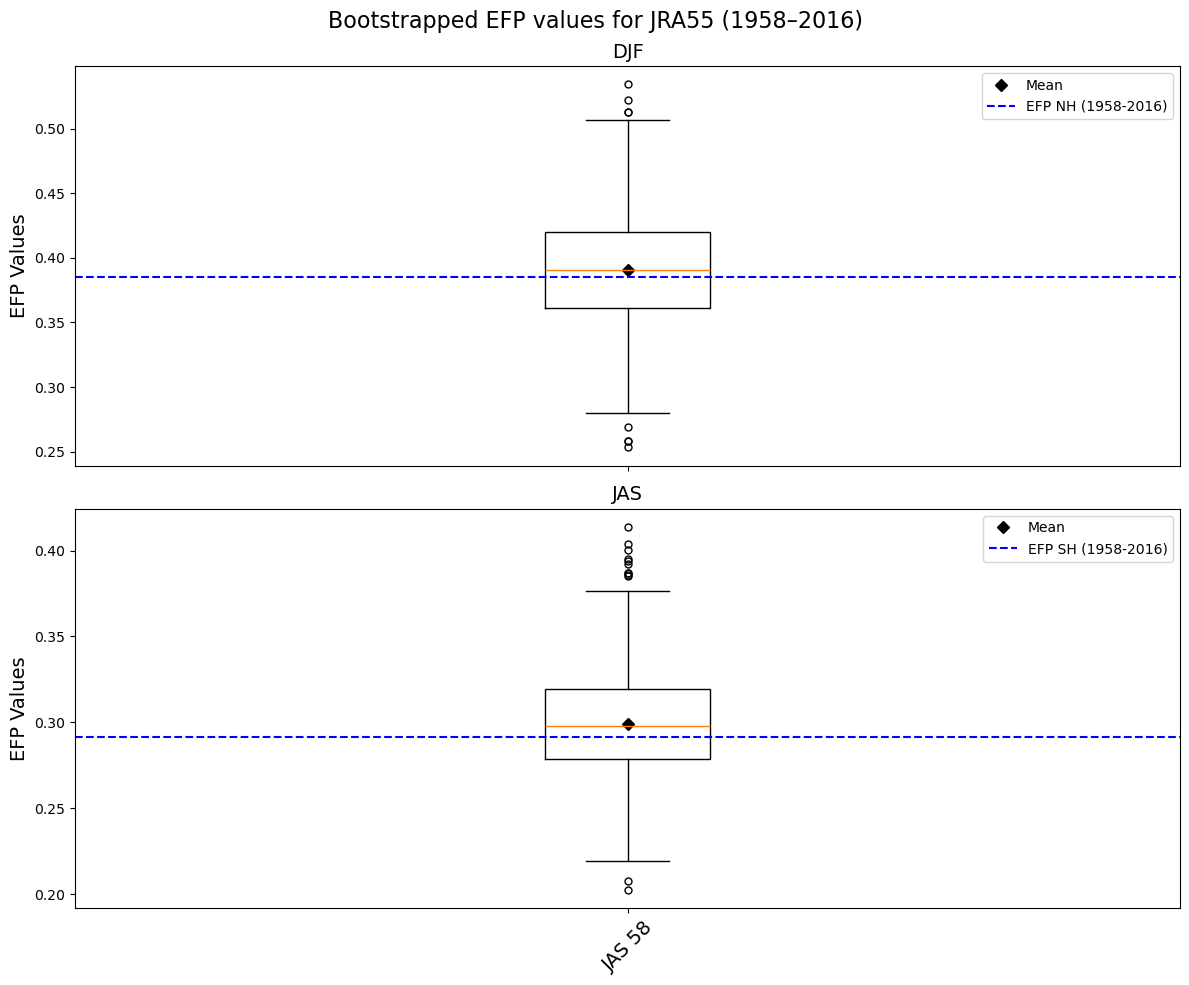

In [16]:


sample_sizes = [58]

# Containers for boxplot data and labels
all_djf_values = []
all_jas_values = []
labels_djf = []
labels_jas = []
mean_djf = []
mean_jas = []

for sample in sample_sizes:
    efp_djf_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1958-2016_djf_efp_values.npy')
    efp_jas_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1958-2016_jas_efp_values.npy')
    
    all_djf_values.append(efp_djf_values)
    all_jas_values.append(efp_jas_values)
    
    labels_djf.append(f'DJF {sample}')
    labels_jas.append(f'JAS {sample}')
    
    mean_djf.append(np.mean(efp_djf_values))
    mean_jas.append(np.mean(efp_jas_values))

# Create a single boxplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)

# DJF subplot
ax1.boxplot(all_djf_values, flierprops=dict(marker='o', color='r', markersize=5))
ax1.plot(np.arange(1, len(mean_djf)+1), mean_djf, 'D', color='black', label='Mean')
ax1.set_title('DJF', fontsize=14)
ax1.set_ylabel('EFP Values', fontsize=14)
ax1.set_xticks(ticks=np.arange(1, len(labels_djf)+1), labels=labels_djf, rotation=45, fontsize=14)
ax1.axhline(y=efp_nh_1958_2016, color='blue', linestyle='--', label='EFP NH (1958-2016)')
ax1.legend()

# JAS subplot
ax2.boxplot(all_jas_values, flierprops=dict(marker='o', color='r', markersize=5))
ax2.plot(np.arange(1, len(mean_jas)+1), mean_jas, 'D', color='black', label='Mean')
ax2.set_title('JAS', fontsize=14)
ax2.set_ylabel('EFP Values', fontsize=14)
ax2.set_xticks(ticks=np.arange(1, len(labels_jas)+1), labels=labels_jas, rotation=45, fontsize=14)
ax2.axhline(y=efp_sh_1958_2016, color='blue', linestyle='--', label='EFP SH (1958-2016)')
ax2.legend()

fig.suptitle('Bootstrapped EFP values for JRA55 (1958–2016)', fontsize=16)
plt.tight_layout()
plt.show()


# 1979-2016

In [17]:
ds = ds.sel(time=slice('1979', '2016'))

djf = dw.seasonal_mean(ds, season='djf', cut_ends=True)
jas = dw.seasonal_mean(ds, season='jas', cut_ends=True)

sample_sizes = [37]

for sample in sample_sizes:
    num_bootstrap_samples = 1000
    # Bootstrap resampling over 'time' for DJF
    bootstrap_indices = np.random.choice(djf.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_djfsets = [djf.isel(time=idx) for idx in bootstrap_indices]
    
    efp_djf_values = []
    for item in bootstrap_djfsets:
        
        efp_djf = ef.calculate_efp(item, data_type='reanalysis', bootstrapping=True)
        efp_djf_values.append(efp_djf)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1979-2016_djf_efp_values.npy'
    np.save(save_path, efp_djf_values)
    
    #-------------------------------------

    # Bootstrap resampling over 'time' for JAS
    bootstrap_indices = np.random.choice(jas.sizes["time"], size=(num_bootstrap_samples, sample), replace=True)
    bootstrap_jassets = [jas.isel(time=idx) for idx in bootstrap_indices]
    
    efp_jas_values = []
    for item in bootstrap_jassets:
        
        efp_jas = ef.calculate_efp(item, data_type='reanalysis', calc_south_hemis=True, bootstrapping=True)
        efp_jas_values.append(efp_jas)
        
    # save the efp values
    save_path = f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1979-2016_jas_efp_values.npy'
    np.save(save_path, efp_jas_values)

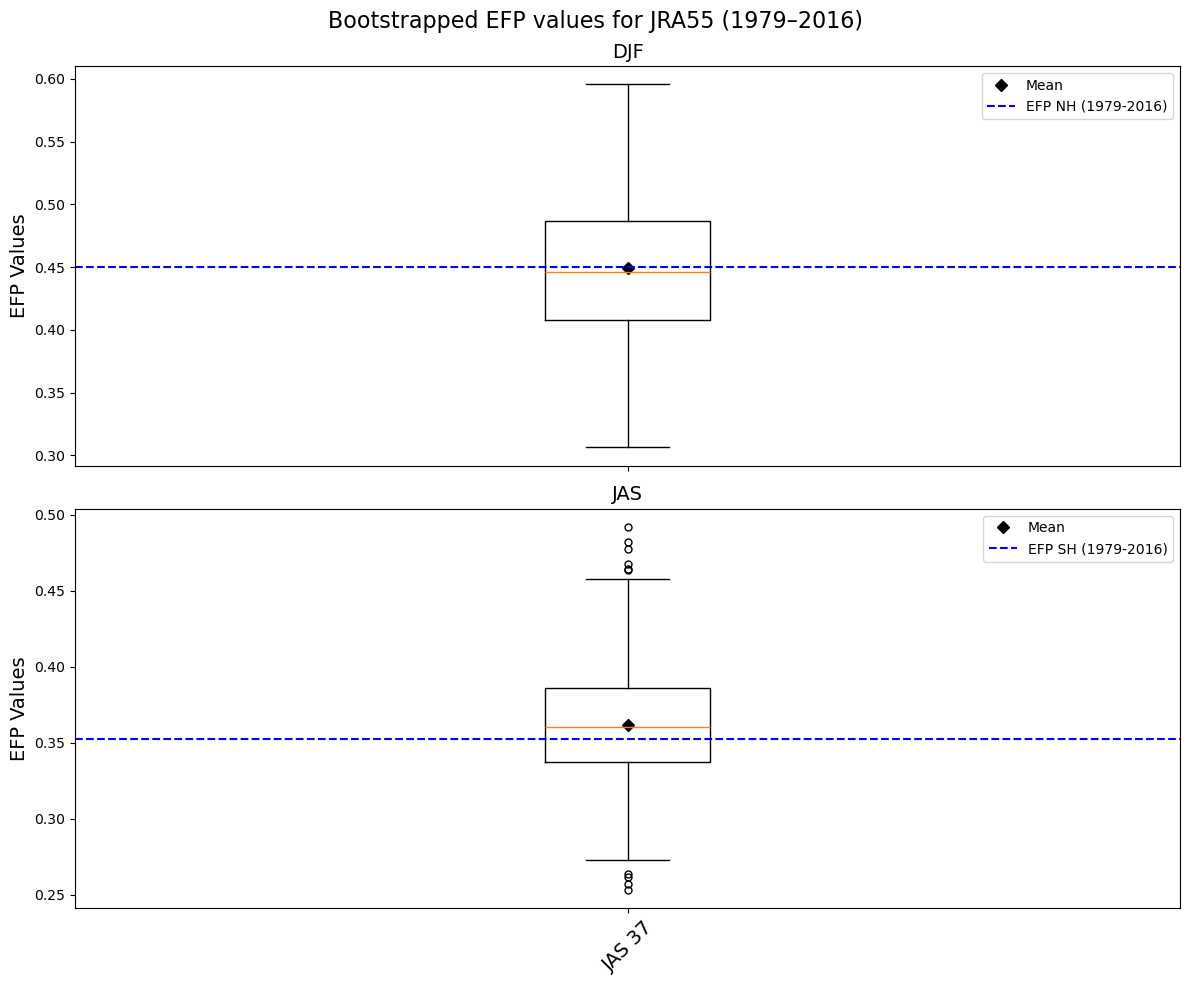

In [18]:
import numpy as np
import matplotlib.pyplot as plt

sample_sizes = [37]

# Containers for boxplot data, labels, and means
all_djf_values = []
all_jas_values = []
labels_djf = []
labels_jas = []
mean_djf = []
mean_jas = []

for sample in sample_sizes:
    efp_djf_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1979-2016_djf_efp_values.npy')
    efp_jas_values = np.load(f'/home/links/ct715/eddy_feedback/chapter1/daily_efp/bootstrap/data/mixed-freq/JRA55_1979-2016_jas_efp_values.npy')
    
    all_djf_values.append(efp_djf_values)
    all_jas_values.append(efp_jas_values)
    
    labels_djf.append(f'DJF {sample}')
    labels_jas.append(f'JAS {sample}')
    
    mean_djf.append(np.mean(efp_djf_values))
    mean_jas.append(np.mean(efp_jas_values))

# Create a single boxplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)

# DJF boxplot with means
ax1.boxplot(all_djf_values, flierprops=dict(marker='o', color='r', markersize=5))
ax1.plot(np.arange(1, len(mean_djf)+1), mean_djf, 'D', color='black', label='Mean')
ax1.set_title('DJF', fontsize=14)
ax1.set_ylabel('EFP Values', fontsize=14)
ax1.set_xticks(ticks=np.arange(1, len(labels_djf)+1), labels=labels_djf, rotation=45, fontsize=14)
ax1.axhline(y=efp_nh_1979_2016, color='blue', linestyle='--', label='EFP NH (1979-2016)')
ax1.legend()

# JAS boxplot with means
ax2.boxplot(all_jas_values, flierprops=dict(marker='o', color='r', markersize=5))
ax2.plot(np.arange(1, len(mean_jas)+1), mean_jas, 'D', color='black', label='Mean')
ax2.set_title('JAS', fontsize=14)
ax2.set_ylabel('EFP Values', fontsize=14)
ax2.set_xticks(ticks=np.arange(1, len(labels_jas)+1), labels=labels_jas, rotation=45, fontsize=14)
ax2.axhline(y=efp_sh_1979_2016, color='blue', linestyle='--', label='EFP SH (1979-2016)')
ax2.legend()

fig.suptitle('Bootstrapped EFP values for JRA55 (1979–2016)', fontsize=16)

plt.tight_layout()
plt.show()
